In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from pyntcloud import PyntCloud

from dataset import ShapeNetDataset
from model import ClassificationNN, SegmentationNN, FeatureTransform, train, Logger
from torch.utils.data import DataLoader, random_split

In [2]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(device)

cuda


![plot](images/model.png)

In [4]:
import subprocess
import os
if os.path.exists('./datasets'):
    pass
else:
    if not os.path.exists('./ModelNet10.zip'):
        subprocess.run(["wget", "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip"])
    subprocess.run(["unzip", "-o", "ModelNet10.zip", "-d", "./datasets/"])



In [5]:
n = 2500

trainset = ShapeNetDataset("datasets/ModelNet2", train=True, n=n)
testset = ShapeNetDataset("datasets/ModelNet2", train=False, n=n)

dataset_length = len(trainset)
train_ratio = 0.7
test_ratio = 0.3

train_len = int(dataset_length * train_ratio)
test_len = dataset_length - train_len

trainset, testset = random_split(trainset, [train_len, test_len])


In [6]:
num_classes = 2
classification_model = ClassificationNN(num_classes).to(device)

In [8]:
lr = 0.01
epochs = 5
batch_size = 64
momentum = 0.9

logger = Logger()

optimizer = torch.optim.Adam(classification_model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(classification_model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
train(classification_model, trainset, testset, optimizer, epochs=epochs, logger=logger, batch_size=batch_size)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:33<00:00, 54.61s/it]


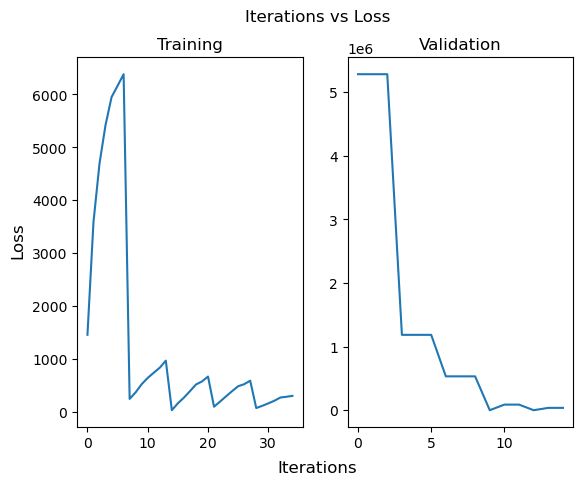

In [9]:
logger.plot_loss()

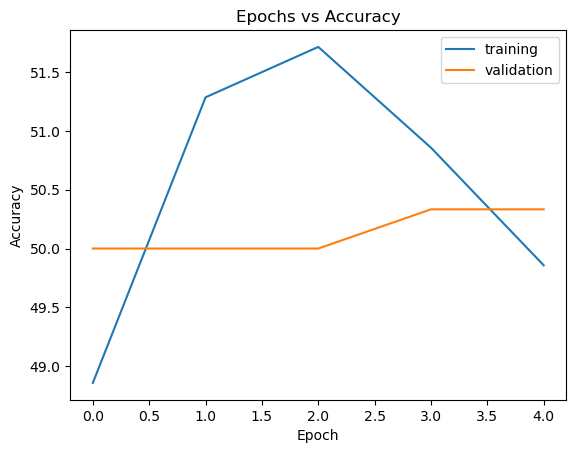

In [10]:
logger.plot_accuracy()

# ModelNet10 Dataset

The ModelNet10 Dataset features 5586 different pointcloud objects across 12 different classes. Below, we show the train/test split for each of the classes.

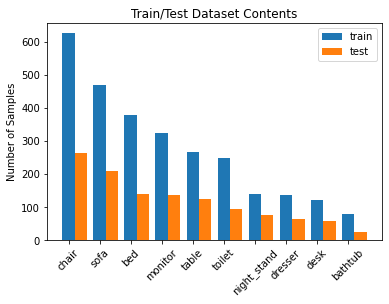

In [ ]:
train_indices = trainset.indices
test_indices = testset.indices

dataset = ShapeNetDataset("datasets/ModelNet10", train=True, n=n)

train_class_counts = dataset.df.loc[train_indices, 'label'].value_counts()
test_class_counts = dataset.df.loc[test_indices, 'label'].value_counts()

x_labels = [dataset.classes[label] for label in train_class_counts.index]
x = range(len(x_labels))

plt.bar(x, train_class_counts, label='train', width=0.4)
plt.bar([xi + 0.4 for xi in range(len(x_labels))], test_class_counts, label='test', width=0.4)
plt.xticks([xi for xi in x], x_labels, rotation=45)
plt.ylabel('Number of Samples')
plt.title('Train/Test Dataset Contents')
plt.legend()

Here, we will show an example of a desk pointcloud. We first print out the first point of its representation. Note that it is a set of unordered (X, Y, Z) point.

In [ ]:
for key, value in dataset.classes.items():
    if value == "desk":
        label = key
        break

idx = dataset.df[dataset.df['label'] == label].index[0]
point_cloud = dataset[idx]
first_point = point_cloud[0].tolist()  
print(f"Class: desk")
print("First point xyz coords")
print(f"x: {first_point[0][0]}, y: {first_point[1][0]}, z: {first_point[2][0]}")
print()

Class: desk
First point xyz coords
x: 12.979410171508789, y: -43.5, z: -3.2979397773742676



Now, we will produce a scatter plot showing the desk's representation by plotting the (x, y, z) points on a 3D scatter plot.

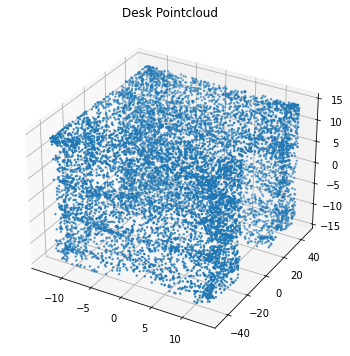

In [ ]:
np_ptcld = point_cloud[0].numpy()
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(np_ptcld[0], np_ptcld[1], np_ptcld[2], s=2)
plt.title('Desk Pointcloud')
plt.show()

# Data Visualization

In [ ]:
n = 10000
train_data = ShapeNetDataset("datasets/ModelNet10", train=True, n=n)
test_data = ShapeNetDataset("datasets/ModelNet10", train=False, n=n)

# Create DataLoaders
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

# Getting points from point cloud
train_data[1000][0] # Is in Pandas DataFrame

tensor([[  5.8223,  11.3676,  10.6173,  ...,   4.0352,  -2.1924,   8.4583],
        [  1.3980,  12.6006,   5.0399,  ..., -10.5824,   7.1787,   2.1283],
        [ -9.5307,  14.1318,   1.1419,  ...,   1.1363,   3.1598, -10.6813]])

In [ ]:
import open3d as o3d
points = (train_data[1000][0]).T
o3d_cloud = o3d.geometry.PointCloud()
o3d_cloud.points = o3d.utility.Vector3dVector(points)
o3d.visualization.draw_geometries([o3d_cloud])

In [ ]:
train_data[10][0].shape

torch.Size([3, 10000])